# Movie Galaxy — Semantic Movie Exploration


## Imports

In [1]:
import os
import pandas as pd
import numpy as np

## Loading Dataset

In [2]:
import kagglehub
movies_path = kagglehub.dataset_download("alanvourch/tmdb-movies-daily-updates")

# animes_path = kagglehub.dataset_download("calebmwelsh/anilist-anime-dataset")

100%|██████████| 292M/292M [00:02<00:00, 145MB/s]

Extracting files...


In [3]:
os.listdir(movies_path)

['TMDB_all_movies.csv']

In [4]:
movies_df = pd.read_csv(f"{movies_path}/TMDB_all_movies.csv")

## Exploring Dataset

In [5]:
# download samble data to view in excel
# sample_movies = movies_df.sample(n=100, random_state=42)
# sample_movies.to_csv("movies_sample_100.csv", index=False)

In [5]:
print("Shape:", movies_df.shape)
print("\nColumns:", movies_df.columns.tolist())
print("\nFirst 3 rows:")
display(movies_df.head(3))
print("\nInfo:")
movies_df.info()
print("\nMissing values (%):")
print((movies_df.isnull().sum() / len(movies_df) * 100).round(2).sort_values(ascending=False))
print("\nBasic stats:")
display(movies_df.describe())

Shape: (1162271, 28)

Columns: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'budget', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'director', 'director_of_photography', 'writers', 'producers', 'music_composer', 'imdb_rating', 'imdb_votes', 'poster_path']

First 3 rows:


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
0,2,Ariel,7.1,367.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,suomi,"Tarja Keinänen, Marja Packalén, Kari Helaseppä...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Aki Kaurismäki,NaN,7.4,9629.0,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg
1,3,Shadows in Paradise,7.3,430.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,"svenska, suomi, English","Haije Alanoja, Mari Rantasila, Matti Pellonpää...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Mika Kaurismäki,NaN,7.4,8496.0,/nj01hspawPof0mJmlgfjuLyJuRN.jpg
2,5,Four Rooms,5.9,2799.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,English,"Antonio Banderas, Ione Skye, Sammi Davis, Paul...","Allison Anders, Quentin Tarantino, Alexandre R...","Andrzej Sekula, Rodrigo García, Guillermo Nava...","Allison Anders, Quentin Tarantino, Alexandre R...","Lawrence Bender, Quentin Tarantino, Alexandre ...",Combustible Edison,6.7,116428.0,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162271 entries, 0 to 1162270
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1162271 non-null  int64  
 1   title                    1162259 non-null  object 
 2   vote_average             1162271 non-null  float64
 3   vote_count               1162271 non-null  float64
 4   status                   1162271 non-null  object 
 5   release_date             1041557 non-null  object 
 6   revenue                  1162271 non-null  float64
 7   runtime                  1162271 non-null  float64
 8   budget                   1162271 non-null  float64
 9   imdb_id                  654195 non-null   object 
 10  original_language        1162271 non-null  object 
 11  original_title           1162260 non-null  object 
 12  overview                 985203 non-null   object 
 13  popularity               1162271 no

,id,vote_average,vote_count,revenue,runtime,budget,popularity,imdb_rating,imdb_votes
count,1.162271e+06,1.162271e+06,1.162271e+06,1.162271e+06,1.162271e+06,1.162271e+06,1.162271e+06,461634.000000,4.616340e+05
mean,8.313141e+05,2.006261e+00,2.262001e+01,7.076448e+05,4.421379e+01,2.799127e+05,8.382831e-01,6.259149,2.808687e+03
std,4.669530e+05,3.056620e+00,3.645048e+02,1.696131e+07,5.500133e+01,4.643605e+06,1.798780e+00,1.325994,3.234866e+04
min,2.000000e+00,0.000000e+00,0.000000e+00,-1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,5.000000e+00
25%,4.324135e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.187000e-01,5.500000,2.000000e+01
50%,8.185780e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+01,0.000000e+00,6.000000e-01,6.400000,5.900000e+01
75%,1.237720e+06,5.000000e+00,1.000000e+00,0.000000e+00,8.500000e+01,0.000000e+00,9.471000e-01,7.100000,2.640000e+02
max,1.638171e+06,1.000000e+01,3.887700e+04,2.923706e+09,1.440000e+04,4.899000e+08,5.161282e+02,10.000000,3.158033e+06


In [6]:
# title, overview, genres, cast, director, year


--- Movies Released Each Year ---


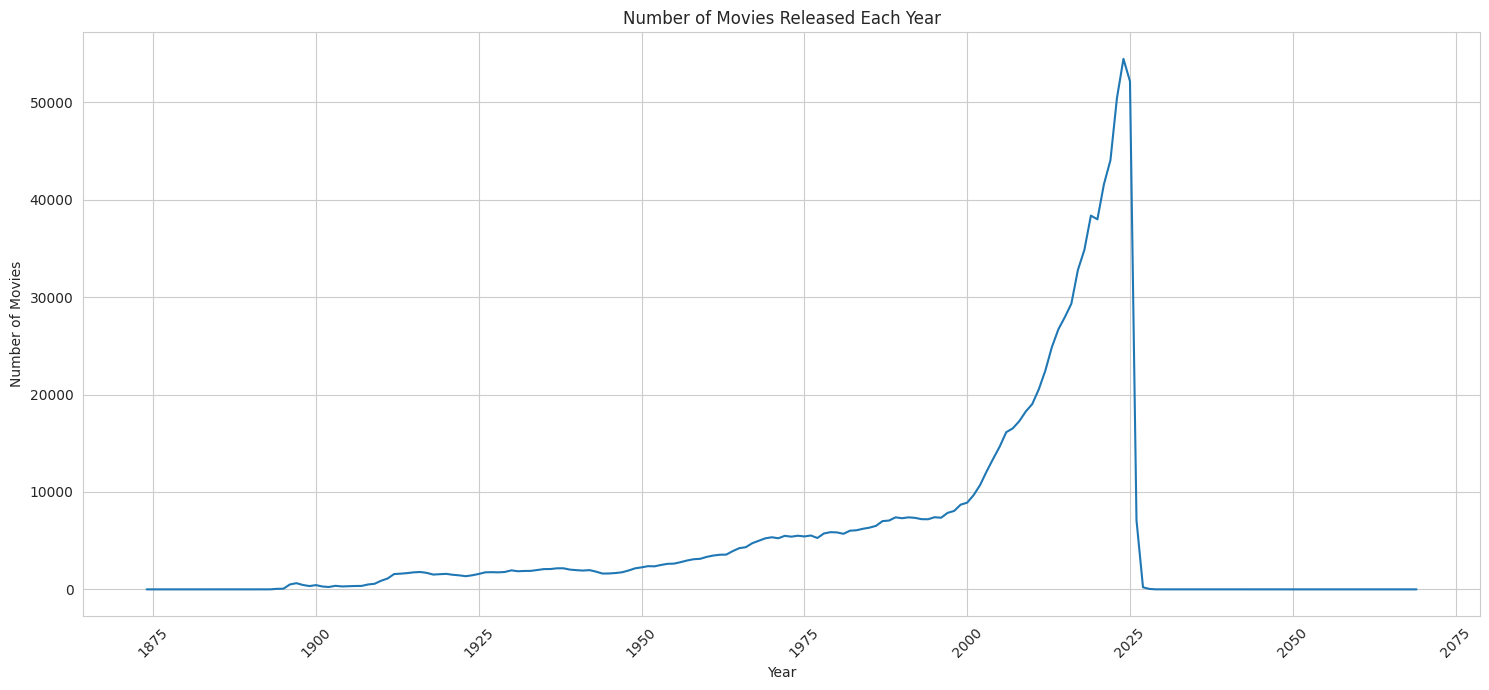


--- Movies by Original Language ---


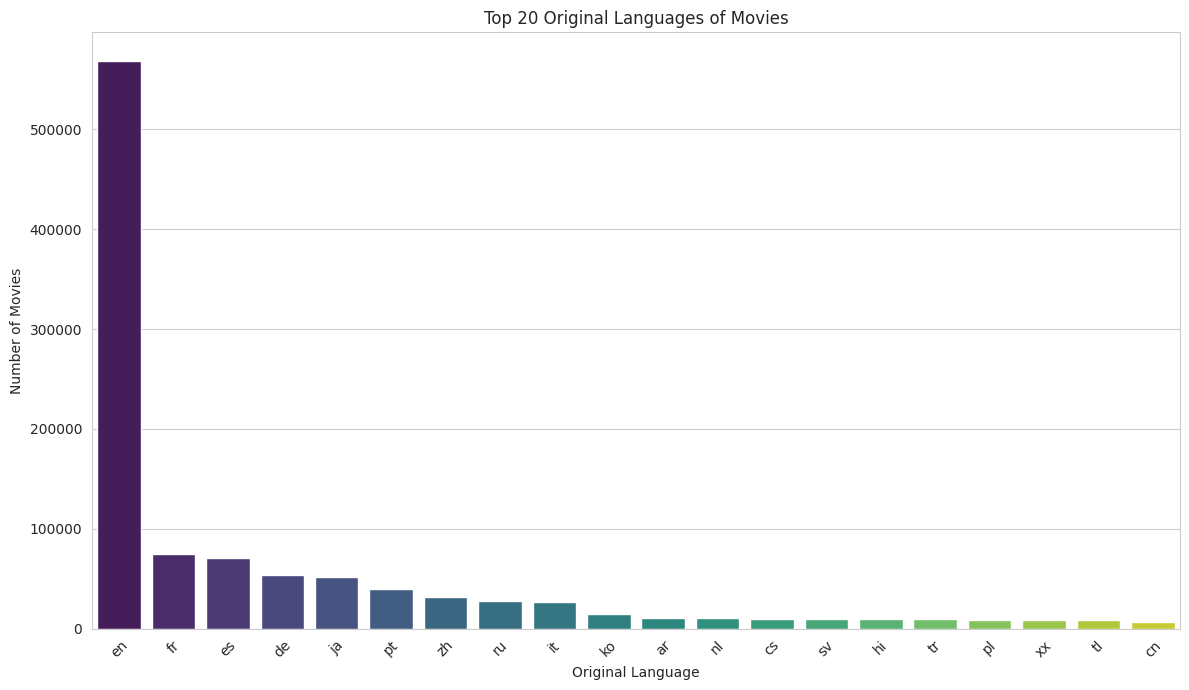

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Set plot style
sns.set_style("whitegrid")

# Plot 1: Number of movies released each year
print("\n--- Movies Released Each Year ---")
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year
year_counts = movies_df['release_year'].value_counts().sort_index()

plt.figure(figsize=(15, 7))
sns.lineplot(x=year_counts.index, y=year_counts.values)
plt.title('Number of Movies Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Movies from each original language
# This plot tells most of the movies are in english so ignore this feature.
print("\n--- Movies by Original Language ---")
language_counts = movies_df['original_language'].value_counts().head(20) # Top 20 languages

plt.figure(figsize=(12, 7))
sns.barplot(x=language_counts.index, y=language_counts.values, hue=language_counts.index, palette='viridis', legend=False)
plt.title('Top 20 Original Languages of Movies')
plt.xlabel('Original Language')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Number of peoples voted
# for 66% of data the count is 0
zero_vote_count = movies_df[movies_df['vote_count'] == 0]
print(f"Number of movies with 0 vote count: {len(zero_vote_count)}")

total_movies = movies_df.shape[0]
percentage_zero_votes = (len(zero_vote_count) / total_movies) * 100
print(f"Percentage of movies with 0 vote count: {percentage_zero_votes:.2f}%")

Number of movies with 0 vote count: 772546
Percentage of movies with 0 vote count: 66.47%


## Clean Data

In [9]:
keep_cols = [
    'id', 'title', 'overview', 'genres', 'cast', 'director',
    'release_date', 'poster_path', 'popularity'
]

df = movies_df[keep_cols].copy()
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year.astype('Int64')
print("Shape after selecting columns:", df.shape)
print(df.dtypes)

Shape after selecting columns: (1162271, 10)
id                int64
title            object
overview         object
genres           object
cast             object
director         object
release_date     object
poster_path      object
popularity      float64
year              Int64
dtype: object


### Handle missing values

In [10]:
df['genres'] = df['genres'].fillna('Unknown')
df['cast'] = df['cast'].fillna('')
df['director'] = df['director'].fillna('Unknown')
df['year'] = df['year'].fillna(0).astype(int)

print("Missing values after filling:")
print(df.isnull().sum())

Missing values after filling:
id                   0
title               12
overview        177068
genres               0
cast                 0
director             0
release_date    120714
poster_path     286546
popularity           0
year                 0
dtype: int64


In [11]:
df = df[
    df['title'].notna() &
    (df['title'].str.strip() != '') &
    df['overview'].notna() &
    (df['overview'] != '') &
    (df['overview'].str.len() >= 20)
].copy()

print("Shape after dropping bad overview rows:", df.shape)
print(df.isnull().sum())

Shape after dropping bad overview rows: (973121, 10)
id                   0
title                0
overview             0
genres               0
cast                 0
director             0
release_date     88024
poster_path     218035
popularity           0
year                 0
dtype: int64


In [12]:
import ast

def get_top_5_cast(cast_value):
    if not cast_value:  # empty string
        return ''

    try:
        # Most TMDB dumps store cast as stringified list: "['Tom Hanks', 'Meg Ryan', ...]"
        if isinstance(cast_value, str) and cast_value.startswith('['):
            cast_list = ast.literal_eval(cast_value)
            if isinstance(cast_list, list):
                return ', '.join(str(name).strip() for name in cast_list[:5])

        # If it's already comma-separated
        elif ',' in cast_value:
            cast_list = [name.strip() for name in cast_value.split(',')]
            return ', '.join(cast_list[:5])

        # Fallback – just keep short
        return str(cast_value)[:150]

    except Exception:
        return ''


df['cast_top5'] = df['cast'].apply(get_top_5_cast)
print("Sample cast cleaning:")
display(df[['title', 'cast', 'cast_top5']].sample(8))

Sample cast cleaning:


,title,cast,cast_top5
380920,Cricket Requiem,,
68455,Liverpool,"Juan Fernández, Giselle Irrazabal, Nieves Cabrera","Juan Fernández, Giselle Irrazabal, Nieves Cabrera"
332371,The Super Snooper,"Bud Jamison, E.L. Dale, Monte Collins, Al Fraz...","Bud Jamison, E.L. Dale, Monte Collins, Al Fraz..."
170754,Sesame Street: Preschool Is Cool!: Counting wi...,,
781850,"Old Man, Con Man","Ewart James Walters, D'NAI PEBBLES, Robin Soan...","Ewart James Walters, D'NAI PEBBLES, Robin Soan..."
130020,Space Junk 3D,"Zach Clark, Em Clark, Howard Henley, Tom Wilki...","Zach Clark, Em Clark, Howard Henley, Tom Wilki..."
430126,Mermaid,Laure Giappiconi,Laure Giappiconi
136331,Breaking the Mould,"Kate Fleetwood, Denis Lawson, John Sessions, D...","Kate Fleetwood, Denis Lawson, John Sessions, D..."


In [14]:
df.shape

(210201, 11)

In [13]:
from datetime import datetime

current_year = datetime.now().year
year_cutoff = current_year - 5

# Filter movies from the last 5 years and update df
df = df[df['year'] >= year_cutoff].copy()

print(f"Number of movies in the last 5 years (from {year_cutoff} to {current_year}): {df.shape[0]}")
print("Shape of the DataFrame with recent movies:", df.shape)

Number of movies in the last 5 years (from 2021 to 2026): 210201
Shape of the DataFrame with recent movies: (210201, 11)
Sample of recent movies:


,id,title,overview,genres,cast,director,release_date,poster_path,popularity,year,cast_top5
3043,5492,Gunner,"While on a camping trip in order to reconnect,...","Action, Thriller, Crime","Grant Feely, Connor DeWolfe, Breana Symone, Yu...",Dimitri Logothetis,2024-08-16,/cS2TXN1YlrCvkZmMxaevC1ZKtEz.jpg,6.1296,2024,"Grant Feely, Connor DeWolfe, Breana Symone, Yu..."
3742,7181,Dusk,When a series of unexplained events begin to e...,Horror,"Dean Williams, Bill Sebastian, Jennifer Sipes,...",Kyle Hodgkinson,2026-03-07,/e2tWEpDPxytFvllRjTrFDcXFXQz.jpg,1.2937,2026,"Dean Williams, Bill Sebastian, Jennifer Sipes,..."
7807,13494,Red Sonja,A young girl rises from the ashes of tragedy t...,"Adventure, Action, Fantasy","Michael Bisping, Max Kraus, Veselin Troyanov, ...",MJ Bassett,2025-07-31,/aE3yh4y0h96CZZpLo0UDFMWZAA9.jpg,11.2791,2025,"Michael Bisping, Max Kraus, Veselin Troyanov, ..."
12311,20425,Inside Better Call Saul: Season Finale,Better Call Saul is a character-driven drama t...,"Music, Documentary",,Unknown,2022-04-11,/dijwK6iIIBe7uWlNG0bXRFdBjVE.jpg,2.6537,2022,
17738,28930,Samurai Priest Vampire Hunter,The comic book has come to life. Tim Thomerso...,"Horror, Action","Tammy Klein, Osa Wallander, Eva Derrek, Chuck ...",Mark Terry,2023-10-06,/n94yMfgkiAwSSLAHSbYiieCSLbr.jpg,0.2973,2023,"Tammy Klein, Osa Wallander, Eva Derrek, Chuck ..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [15]:
def build_text(row):
    parts = []

    parts.append(f"Title: {row['title']}.")

    overview = row['overview'][:650].rstrip(" .!?")
    parts.append(f"Overview: {overview}.")

    if row['genres'] != 'Unknown':
        parts.append(f"Genres: {row['genres']}.")

    if row['cast_top5']:
        parts.append(f"Cast: {row['cast_top5']}.")

    if row['director'] != 'Unknown':
        parts.append(f"Director: {row['director']}.")

    if row['year'] != 0:
        parts.append(f"Year: {row['year']}.")

    # Join as natural sentences + add E5 prefix
    return "passage: " + " ".join(parts)


from tqdm.auto import tqdm

tqdm.pandas(desc="Building embedding text")
df['text_to_embed'] = df.progress_apply(build_text, axis=1)

print("Sample text to embed:")
display(df[['title', 'text_to_embed']].sample(3))


Building embedding text:   0%|          | 0/210201 [00:00<?, ?it/s]

Sample text to embed:


,title,text_to_embed
1118081,"We Miss, We Meet, We Move On","passage: Title: We Miss, We Meet, We Move On. ..."
614360,Bhai,passage: Title: Bhai. Overview: The gulf of un...
695384,Death Does Not Exist,passage: Title: Death Does Not Exist. Overview...


In [16]:
df['text_to_embed'].iloc[0]

"passage: Title: Gunner. Overview: While on a camping trip in order to reconnect, war veteran Colonel Lee Gunner must save his two sons from a gang of violent bikers when they're kidnapped after accidentally stumbling upon to a massive drug operation. Genres: Action, Thriller, Crime. Cast: Grant Feely, Connor DeWolfe, Breana Symone, Yulia Klass, Creek Wilson. Director: Dimitri Logothetis. Year: 2024."

In [17]:
df.shape

(210201, 12)

In [19]:
# Save the cleaned version
df.to_parquet('movies_cleaned_for_embedding.parquet', index=False)

### Create Embeddings

In [18]:
!pip install -q sentence-transformers

In [19]:
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm.auto import tqdm
import os
import torch

# ────────────────────────────────────────────────
# CONFIG
# ────────────────────────────────────────────────
model_name = "intfloat/multilingual-e5-large"
batch_size = 192
checkpoint_every = 5000
output_dir = "./checkpoints"

embeddings_file = "movie_embeddings.npy"
progress_file = "embedding_progress.npy"

os.makedirs(output_dir, exist_ok=True)

full_embeddings_path = os.path.join(output_dir, embeddings_file)
progress_path = os.path.join(output_dir, progress_file)

# ────────────────────────────────────────────────
# DATA
# ────────────────────────────────────────────────
texts = df["text_to_embed"].tolist()
total = len(texts)

# Resume position
if os.path.exists(progress_path):
    start_idx = int(np.load(progress_path)[0])
    print(f"Resuming from index {start_idx} / {total}")
else:
    start_idx = 0
    print("Starting from beginning")

# ────────────────────────────────────────────────
# MODEL
# ────────────────────────────────────────────────
print(f"Loading {model_name}")
model = SentenceTransformer(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# speed + stability improvements
torch.set_float32_matmul_precision("high")
if device == "cuda":
    torch.cuda.empty_cache()

print(f"Using device: {device}")

# Automatically detect embedding dimension
embedding_dim = model.get_sentence_embedding_dimension()
print(f"Embedding dimension: {embedding_dim}")

# ────────────────────────────────────────────────
# CREATE / LOAD MEMORY-MAPPED ARRAY
# ────────────────────────────────────────────────
if os.path.exists(full_embeddings_path):
    embeddings = np.memmap(
        full_embeddings_path,
        dtype="float32",
        mode="r+",
        shape=(total, embedding_dim),
    )
    print("Loaded existing embedding memmap")
else:
    embeddings = np.memmap(
        full_embeddings_path,
        dtype="float32",
        mode="w+",
        shape=(total, embedding_dim),
    )
    print("Created new embedding memmap")

# ────────────────────────────────────────────────
# EMBEDDING LOOP (RESUMABLE)
# ────────────────────────────────────────────────
print("Starting / resuming embedding...")

save_interval_batches = max(1, checkpoint_every // batch_size)

for step, i in enumerate(
    tqdm(range(start_idx, total, batch_size), desc="Embedding batches")
):
    end = min(i + batch_size, total)
    chunk_texts = texts[i:end]

    try:
        chunk_emb = model.encode(
            chunk_texts,
            batch_size=batch_size,
            show_progress_bar=False,
            normalize_embeddings=True,
            convert_to_numpy=True,
        )

        embeddings[i:end] = chunk_emb

        # periodic checkpoint
        if step % save_interval_batches == 0 or end == total:
            embeddings.flush()  # write memmap to disk
            np.save(progress_path, np.array([end]))
            print(f"Checkpoint saved at {end}/{total}")

    except Exception as e:
        print(f"Error in batch {i}-{end}: {e}")
        print("Saving progress before exit...")
        embeddings.flush()
        np.save(progress_path, np.array([i]))
        raise e

# Final save
embeddings.flush()
np.save(progress_path, np.array([total]))

print("\n✅ Embedding complete!")
print(f"Saved embeddings at: {full_embeddings_path}")
print(f"Final shape: ({total}, {embedding_dim})")


Starting from beginning
Loading intfloat/multilingual-e5-large


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: intfloat/multilingual-e5-large
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Using device: cuda
Embedding dimension: 1024
Created new embedding memmap
Starting / resuming embedding...


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Embedding batches:   0%|          | 0/1095 [00:00<?, ?it/s]

Checkpoint saved at 192/210201
Checkpoint saved at 5184/210201
Checkpoint saved at 10176/210201
Checkpoint saved at 15168/210201
Checkpoint saved at 20160/210201
Checkpoint saved at 25152/210201
Checkpoint saved at 30144/210201
Checkpoint saved at 35136/210201
Checkpoint saved at 40128/210201
Checkpoint saved at 45120/210201
Checkpoint saved at 50112/210201
Checkpoint saved at 55104/210201
Checkpoint saved at 60096/210201
Checkpoint saved at 65088/210201
Checkpoint saved at 70080/210201
Checkpoint saved at 75072/210201
Checkpoint saved at 80064/210201
Checkpoint saved at 85056/210201
Checkpoint saved at 90048/210201
Checkpoint saved at 95040/210201
Checkpoint saved at 100032/210201
Checkpoint saved at 105024/210201
Checkpoint saved at 110016/210201
Checkpoint saved at 115008/210201
Checkpoint saved at 120000/210201
Checkpoint saved at 124992/210201
Checkpoint saved at 129984/210201
Checkpoint saved at 134976/210201
Checkpoint saved at 139968/210201
Checkpoint saved at 144960/210201
Che

### Visualisation

In [20]:
!zip -r checkpoints.zip ./checkpoints
from google.colab import files
files.download('checkpoints.zip')

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/movie_embeddings.npy (deflated 7%)
  adding: checkpoints/embedding_progress.npy (deflated 46%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
import numpy as np
import pandas as pd
import os

# Load embeddings
embeddings_path = './checkpoints/movie_embeddings.npy'
# Load as memory-mapped array, specifying dtype and shape
# The shape is (total, embedding_dim) from the embedding cell's output
total_embeddings = 210201  # Value of 'total' from previous embedding cell
embedding_dimension = 1024 # Value of 'embedding_dim' from previous embedding cell
embeddings = np.memmap(embeddings_path, dtype='float32', mode='r', shape=(total_embeddings, embedding_dimension))

# Prepare metadata
# Ensure 'df' is the filtered DataFrame used for embeddings
# It should contain 'title', 'genres', 'cast_top5', 'director', 'year'
metadata_df = df[['title', 'genres', 'cast_top5', 'director', 'year']].copy()

# Create a single label for each movie by concatenating relevant metadata
# This will be displayed when hovering over points in Projector
metadata_df['label'] = metadata_df.apply(
    lambda row: f"{row['title']} ({row['year']}) - {row['genres']} - {row['cast_top5']}",
    axis=1
)

# Save embeddings to TSV
embeddings_tsv_path = 'embeddings.tsv'
np.savetxt(embeddings_tsv_path, embeddings, delimiter='\t')
print(f"Embeddings saved to {embeddings_tsv_path}")

# Save metadata to TSV
metadata_tsv_path = 'metadata.tsv'
metadata_df['label'].to_csv(metadata_tsv_path, sep='\t', index=False, header=False)
print(f"Metadata saved to {metadata_tsv_path}")

print("\nNow you can upload these two files to https://projector.tensorflow.org/")

Embeddings saved to embeddings.tsv
Metadata saved to metadata.tsv

Now you can upload these two files to https://projector.tensorflow.org/


In [ ]:
!unzip checkpoints.zip